In [101]:

from splat.read_colmap import read_images_text, qvec2rotmat
from splat.scene import GaussianScene
import pycolmap
import torch 
import torch.nn as nn
import numpy as np

reconstruction = pycolmap.Reconstruction("/Users/derek/Desktop/colmap/gerrard-hall/sparse/0")

points3d = reconstruction.points3D
images = read_images_text("/Users/derek/Desktop/colmap/gerrard-hall/sparse/images.txt")
cameras = reconstruction.cameras

all_points3d = []
all_point_colors = []
for idx, point in enumerate(points3d.values()):
    # I would assume this is seeing it from multiple images
    if point.track.length() >= 5:
        all_points3d.append(point.xyz)
        all_point_colors.append(point.color / 256)
    # if idx == 10000: break
        
scene = GaussianScene(torch.Tensor(np.array(all_points3d)), torch.Tensor(np.array(all_point_colors)))

In [102]:
with torch.no_grad():
    covariance_3d = scene.get_3d_covariance_matrix()
    # gets around the 99% mark
    point = scene.points
    point[:, 0] = point[:, 0] + 2.5 * covariance_3d[:, 0, 0]
    point[:, 1] = point[:, 1] + 2.5 * covariance_3d[:, 1, 1]
    point[:, 2] = point[:, 2] + 2.5 * covariance_3d[:, 2, 2]


In [103]:
# project all points to 2d
from splat.utils import get_intrinsic_matrix, get_extrinsic_matrix

image_num = 14

fx, fy, cx, cy = cameras[1].params[:4]
intrinsic_homogeneous = get_intrinsic_matrix(fx, fy, cx, cy)
image_qvec = images[image_num].qvec
image_tvec = images[image_num].tvec
# normalize the qvec
# image_qvec = image_qvec / np.linalg.norm(image_qvec)
image_rotation_matrix = qvec2rotmat(image_qvec)
image_translation = torch.Tensor(image_tvec)
extrinsic_matrix = get_extrinsic_matrix(image_rotation_matrix, image_translation)

points, z, covariances = scene.get_points_and_covariance(extrinsic_matrix=extrinsic_matrix, intrinsic_matrix=intrinsic_homogeneous)

In [105]:
point = scene.points[:1]
covariance = scene.get_3d_covariance_matrix()[:1]

In [107]:
import math
new_point = torch.cat([point, torch.ones(point.shape[0], 1)], dim=1)
points_in_camera_coords = extrinsic_matrix @ new_point.T
W = extrinsic_matrix[:3, :3]
x_comp = points_in_camera_coords[0, 0]
y_comp = points_in_camera_coords[1, 0]
z_comp = points_in_camera_coords[2, 0]
f_x = intrinsic_homogeneous[0, 0]
f_y = intrinsic_homogeneous[1, 1]

def clamp(value, min_value, max_value):
    return max(min_value, min(value, max_value))

aspect = f_x / f_y
# tanfovx = math.tan(viewpoint_camera.FoVx * 0.5)
# tanfovy = math.tan(viewpoint_camera.FoVy * 0.5)
tanFovX = 1 / f_x
tanFovY = 1 / (fy * aspect)
limX = 1.3 * tanFovX
limY = 1.3 * tanFovY
x_comp = clamp(x_comp / z_comp, -limX, limX) * z_comp
y_comp = clamp(y_comp / z_comp, -limY, limY) * z_comp


covariance = W @ covariance @ W.T
f = f_x


jacobian = torch.zeros((3, 3), device=points.device)
jacobian[0, 0] = f / z_comp
jacobian[1, 1] = f / z_comp
jacobian[0, 2] = -f * x_comp / (z_comp**2)
jacobian[1, 2] = -f * y_comp / (z_comp**2)

cov = jacobian @ W @ covariance @ W.T @ jacobian.T
cov

tensor([[[ 5.5805e+02, -2.6979e-05,  0.0000e+00],
         [-4.3600e-05,  5.5805e+02,  0.0000e+00],
         [ 0.0000e+00,  0.0000e+00,  0.0000e+00]]],
       grad_fn=<UnsafeViewBackward0>)

In [96]:
cov[0, :2, :2]

tensor([[ 5.5743e+02, -1.9657e-04],
        [-1.9368e-04,  5.5743e+02]], grad_fn=<SliceBackward0>)

In [92]:
x_comp

tensor(1.6829, grad_fn=<SelectBackward0>)

In [70]:
jacobian.T

tensor([[-2914.3435,     0.0000,     0.0000],
        [    0.0000, -2913.5732,     0.0000],
        [ 3142.5115,  -303.4549,     0.0000]], grad_fn=<PermuteBackward0>)

In [67]:
jacobian

tensor([[-2914.3435,     0.0000,  3142.5115],
        [    0.0000, -2913.5732,  -303.4549],
        [    0.0000,     0.0000,     0.0000]], grad_fn=<CopySlices>)

In [62]:
W.shape

torch.Size([3])

In [58]:
points_in_camera_coords

tensor([[1.6829],
        [0.7535],
        [2.6617],
        [1.0000]], grad_fn=<MmBackward0>)

In [55]:
covariances

tensor([[[ 7.8222e+02,  9.9824e+01],
         [ 9.9824e+01,  6.0258e+02]],

        [[ 4.8849e+02, -3.6892e+01],
         [-3.6892e+01,  3.8834e+02]],

        [[ 4.4514e+02,  5.8201e+01],
         [ 5.8201e+01,  3.4272e+02]],

        ...,

        [[ 1.2684e+03, -3.0435e+01],
         [-3.0435e+01,  1.2224e+03]],

        [[ 4.2450e+02, -3.5269e+01],
         [-3.5269e+01,  4.8587e+02]],

        [[ 1.0212e+02,  1.0920e+00],
         [ 1.0920e+00,  9.7914e+01]]], grad_fn=<StackBackward0>)

In [4]:
import torch

with torch.no_grad():
    output_scene = scene.render_scene(
        projected_points=points,
        projected_covariances=covariances,
        z_component=z,
        height = 1000,
        width = 3000,
        tile_size=64
    )

torch.Size([3064, 1064, 3]) 46 15


100%|██████████| 46/46 [00:17<00:00,  2.68it/s]


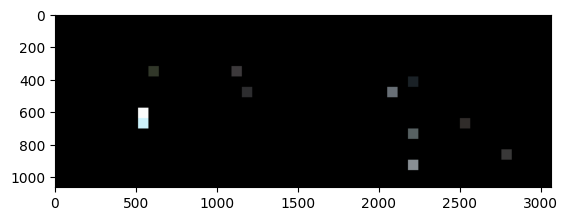

In [5]:
from matplotlib import pyplot as plt

plt.imshow(output_scene.detach().numpy().transpose(1, 0, 2))

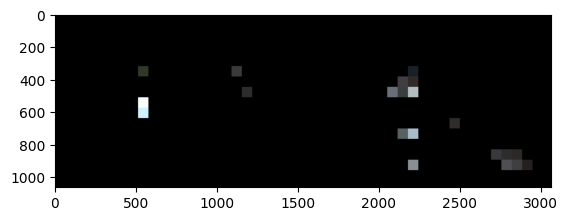

In [5]:
from matplotlib import pyplot as plt

plt.imshow(output_scene.detach().numpy().transpose(1, 0, 2))

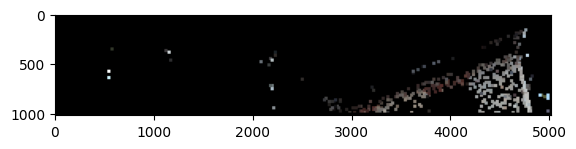

In [4]:
from matplotlib import pyplot as plt

plt.imshow(output_scene.detach().numpy().transpose(1, 0, 2))